In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
statregulartransitions_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1-Score': []
}

indaccs = {}

In [7]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    #X_train = subject_df.loc[train_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #X_test = subject_df.loc[test_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #Y_train = subject_df.loc[train_index, "rhythmLabel"]
    #Y_test = subject_df.loc[test_index, "rhythmLabel"]
    
    X_train = subject_df.iloc[train_index, 6].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 6].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statregulartransitions_dic['Run Time'].append(elapsed)
statregulartransitions_dic['Accuracy'].append(np.mean(acc_score))
statregulartransitions_dic['Standard Error'].append(np.std(acc_score))
statregulartransitions_dic['Sensitivity'].append(sensitivity)
statregulartransitions_dic['Specificity'].append(specificity)
statregulartransitions_dic['Precision'].append(precision)
statregulartransitions_dic['F1-Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.19926682200000023 seconds ---

Accuracy of each fold: 
 [0.8818363888460946, 0.8790446841294299, 0.8825885978428352, 0.8796610169491526, 0.8853620955315871]
Avg accuracy: 0.8816985566598199
Std of accuracy : 
0.0022550962535594957

[[17772  1654]
 [ 2185 10840]]

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     19426
           1       0.87      0.83      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.88      0.87      0.88     32451
weighted avg       0.88      0.88      0.88     32451

0.9148563780500361
0.8322456813819578
0.8905146064037681
0.9025213924789883


In [8]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []


for train_index, test_index in kf.split(subject_df):
  
    X_train = subject_df.iloc[train_index, 6].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 6].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    
    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statregulartransitions_dic['Run Time'].append(elapsed)
statregulartransitions_dic['Accuracy'].append(np.mean(acc_score))
statregulartransitions_dic['Standard Error'].append(np.std(acc_score))
statregulartransitions_dic['Sensitivity'].append(sensitivity)
statregulartransitions_dic['Specificity'].append(specificity)
statregulartransitions_dic['Precision'].append(precision)
statregulartransitions_dic['F1-Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.37156627699999945 seconds ---

Accuracy of each fold: 
 [0.8807579725774148, 0.8764252696456086, 0.8810477657935285, 0.8801232665639446, 0.8845916795069337]
Avg accuracy: 0.8805891908174861
Std of accuracy : 
0.002600539133946685

[[17854  1572]
 [ 2303 10722]]

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     19426
           1       0.87      0.82      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.88      0.87      0.87     32451
weighted avg       0.88      0.88      0.88     32451

0.9190775249665397
0.8231861804222649
0.8857468869375403
0.9021044387742212


In [9]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 6].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 6].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statregulartransitions_dic['Run Time'].append(elapsed)
statregulartransitions_dic['Accuracy'].append(np.mean(acc_score))
statregulartransitions_dic['Standard Error'].append(np.std(acc_score))
statregulartransitions_dic['Sensitivity'].append(sensitivity)
statregulartransitions_dic['Specificity'].append(specificity)
statregulartransitions_dic['Precision'].append(precision)
statregulartransitions_dic['F1-Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.6791940089999997 seconds ---

Accuracy of each fold: 
 [0.8818363888460946, 0.877657935285054, 0.8836671802773498, 0.8804314329738059, 0.8855161787365177]
Avg accuracy: 0.8818218232237645
Std of accuracy : 
0.002695365106270375

[[17824  1602]
 [ 2233 10792]]

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     19426
           1       0.87      0.83      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.88      0.87      0.88     32451
weighted avg       0.88      0.88      0.88     32451

0.9175332029239164
0.8285604606525911
0.8886672982001297
0.902869589443558


In [10]:
#KNN-CV
KNN_result = []
X=subject_df.iloc[:,6].values.reshape(-1,1)
Y=subject_df.iloc[:,-1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.8551841  0.87488444 0.85885978 0.86040062 0.8751926 ]

Avg accuracy: 0.8649043086563617

K=2

Accuracy of each fold: 
 [0.83854568 0.8596302  0.84530046 0.8394453  0.85439137]

Avg accuracy: 0.8474626025985014

K=3

Accuracy of each fold: 
 [0.89446927 0.88967643 0.89491525 0.88767334 0.89414484]

Avg accuracy: 0.8921758252922917

K=4

Accuracy of each fold: 
 [0.88799877 0.88228043 0.88844376 0.88582435 0.88613251]

Avg accuracy: 0.8861359630580115

K=5

Accuracy of each fold: 
 [0.89600986 0.88967643 0.89922958 0.89491525 0.89738059]

Avg accuracy: 0.8954423417608689

K=6

Accuracy of each fold: 
 [0.89446927 0.88613251 0.89676425 0.88798151 0.88983051]

Avg accuracy: 0.8910356095758047

K=7

Accuracy of each fold: 
 [0.89770451 0.89399076 0.90215716 0.89460709 0.90015408]

Avg accuracy: 0.8977227209702946

K=8

Accuracy of each fold: 
 [0.89616392 0.89214176 0.89753467 0.89337442 0.89953775]

Avg accuracy: 0.895750503423135

K=9

Accuracy of each fol

In [11]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=19)

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    X_train = subject_df.iloc[train_index, 6].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 6].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statregulartransitions_dic['Run Time'].append(elapsed)
statregulartransitions_dic['Accuracy'].append(np.mean(acc_score))
statregulartransitions_dic['Standard Error'].append(np.std(acc_score))
statregulartransitions_dic['Sensitivity'].append(sensitivity)
statregulartransitions_dic['Specificity'].append(specificity)
statregulartransitions_dic['Precision'].append(precision)
statregulartransitions_dic['F1-Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score

---Run time is 115.389740549 seconds ---

Accuracy of each fold: 
 [0.9018641195501463, 0.8929121725731896, 0.9052388289676425, 0.9007704160246534, 0.9077041602465331]
Avg accuracy: 0.901697939472433
Std of accuracy : 
0.0050336905343250585

[[17313  2113]
 [ 1077 11948]]

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     19426
           1       0.85      0.92      0.88     13025

    accuracy                           0.90     32451
   macro avg       0.90      0.90      0.90     32451
weighted avg       0.90      0.90      0.90     32451

0.8912282507978997
0.9173128598848369
0.9414355628058727
0.915644171779141


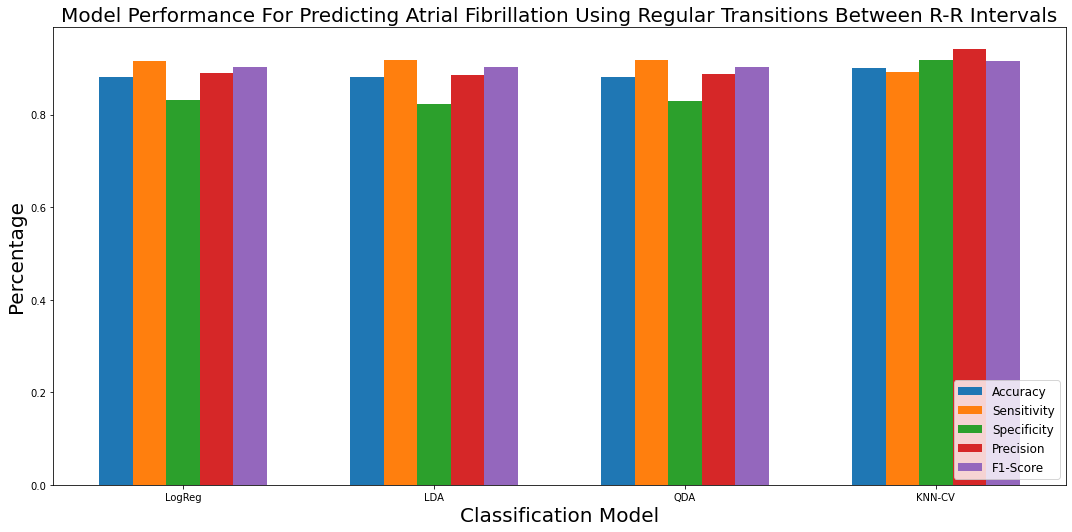

In [12]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statregulartransitions_dic["Accuracy"]
sensitivities = statregulartransitions_dic["Sensitivity"]
specificities = statregulartransitions_dic["Specificity"]
precisions = statregulartransitions_dic["Precision"]
f1_scores = statregulartransitions_dic["F1-Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1-Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Regular Transitions Between R-R Intervals', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('RegTransModel.png')

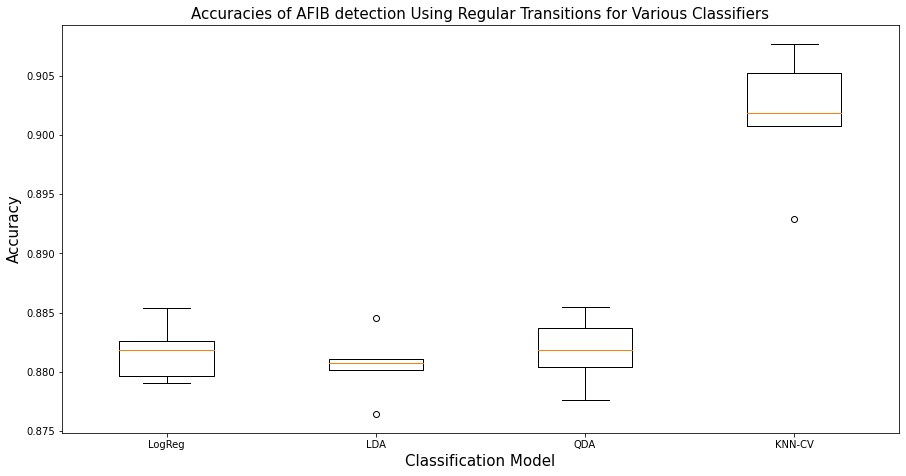

In [13]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using Regular Transitions for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('RegTransBox.png')

In [15]:
rmsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statregulartransitions_dic["Accuracy"],
                                statregulartransitions_dic["Standard Error"],
                                statregulartransitions_dic["Sensitivity"],
                                statregulartransitions_dic["Specificity"],
                                statregulartransitions_dic["Precision"],
                                statregulartransitions_dic["F1-Score"],
                                statregulartransitions_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

rmsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.881699,0.002255,0.914856,0.832246,0.890515,0.902521,0.199267
LDA,0.880589,0.002601,0.919078,0.823186,0.885747,0.902104,0.371566
QDA,0.881822,0.002695,0.917533,0.828560,0.888667,0.902870,0.679194
KNN-CV,0.901698,0.005034,0.891228,0.917313,0.941436,0.915644,115.389741
